## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.stats import norm

## Black-Scholes equations for call and put options

In [2]:
def black_scholes_call(S0, K, T, r, v):
    d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))   
    d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
    
    bs_option_price = (S0 * norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * norm.cdf(d2, 0.0, 1.0))

    return bs_option_price

In [3]:
def black_scholes_put(S0, K, T, r, v):
    d1 = (log((S0 / K)) + (r + 0.5 * (v ** 2)) * T) / (v * sqrt(T))   
    d2 = (log((S0 / K)) + (r - 0.5 * (v ** 2)) * T) / (v * sqrt(T))
    
    bs_option_price = (K * exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S0 * norm.cdf(-d1, 0.0, 1.0))
    
    return bs_option_price

## Computing Vega
The Black-Scholes formula depends on a number of variables, for which derivatives can be computed. These so-called 'Greeks' serve as measures of the option price's sensitivity with respect to its input. The Greek Vega ${\mathcal {V}}$ indicates the sensitivity of the option value with respect to its volatility.

As the Newton-Raphson method depends on a derivative of the function of interest, we utilize Vega as this derivative. The intuition is that, if we observe a large difference between computed price and target price, we perform a larger update on the implied volatility. The closer we get to the target, the smaller the updates become.

In [4]:
def black_scholes_vega(S, K, T, r, v):
    d1 = (log(S / K) + (r + 0.5 * v ** 2) * T) / (v * sqrt(T))
    
    bs_vega = S * norm.pdf(d1) * sqrt(T)
    return bs_vega

In [5]:
"""Implied volatility is found using the Newton-Raphson method"""
def compute_implied_volatility(true_price, S, K, r, T, n, call_put, exercise_policy):
    MAX_NO_ITERATIONS = 100
    MAX_VOL_UPDATE = 0.1
    ACCURACY = 1.0e-5
    
    
    # Check if feasible solution exists (if not, return implied volatility of 0)
    if call_put=='Call' and black_scholes_call(S, K, T, r, 1.0e-5) > true_price:
        print('No feasible solution exists for strike price', K)
        return 1.0e-5
    
    if call_put=='Put' and black_scholes_put(S, K, T, r, 1.0e-5) > true_price:
        print('No feasible solution exists for strike price', K)
        return 1.0e-5
    
    implied_vol = .5 # Initial estimate for implied volatility 
    
    for i in range(MAX_NO_ITERATIONS):
        # Compute price with binomial lattice, using current estimate for implied volatility
        if call_put=='Call':
            model_price = black_scholes_call(S, K, T, r, implied_vol)
        elif call_put=='Put':
            model_price = black_scholes_put(S, K, T, r, implied_vol)
            
        # Compute difference between model price and market price (the root) 
        diff = model_price - true_price

        # Terminate algorithm if desired precision has been hit 
        if (abs(diff) < ACCURACY):
            return implied_vol
        
        # Update implied volatility based on vega and observed error
        vega = black_scholes_vega(S, K, T, r, implied_vol)

        implied_vol -= np.clip(diff/vega, -MAX_VOL_UPDATE, MAX_VOL_UPDATE)
        
    # If maximum number of iterations is hit, simply return best estimate so far
    return implied_vol

## Newton-Raphson method
We find the implied volatility with the Newton-Raphson method, a numerical solution method that aims to find the root of a function by utilizing its derivative. In general form, the Newton-Raphson method may be described as follows:

$x_{n+1}=x_{n}-{\frac {f(x_{n})}{f'(x_{n})}}$

The intuition behind the method is to perform a number of iterations to estimate the implied volatility. It starts with a certain estimate for the implied volatility, computes the Black-Scholes price with that volatility, and computes the error with the real market price. Subsequently, the volatility is updated in a direction that reduces the error. Each iteration should yield a smaller error between model- and real price, until the error falls below a predefined precision. The algorithm will fail if no positive volatility exists for which the Black-Scholes equation fits the market price.

The Newton-Raphson method is a root-finding algorithm, i.e., it tries to find the point for which the function becomes 0. For visualisation purposes we use the Black-Scholes call function. By subtracting the market price $C^*(S,T)$ from our model estimate, we find the root when market price equals the model price. The derivative over volatility yields vega, note this derivative is equivalent for puts and calls. Formally, the procedure is defined as follows: 


$\sigma_{n+1}=\sigma_{n}-{\frac {N(d_{1})S-N(d_{2})Ke^{-rT}-C^*(S,T)}{S N'(d_{1}){\sqrt {T}}\,)}}$

s.t.

$\\d_{1}={\frac {1}{\sigma {\sqrt {T}}}}\left[\ln \left({\frac {S}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)T\right]\\d_{2}=d_{1}-\sigma {\sqrt {T}}$


## Plot function

In [6]:
def plot_vol(implied_vol_list, implied_vol_given_list, strike_prices):
    x = strike_prices
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1]) 
    y = implied_vol_list
    z = implied_vol_given_list
    ax.plot(x, y, label = "Implied volatilities (computed)")
    ax.plot(x, z, label = "Implied volatilities (given)")
    ax.set_xlabel('Strike price')
    ax.set_ylabel('Implied volatility')
    ax.set_title('Volatility smile')
    
    strike_labels = strike_prices[::10]
    min_vol = min(implied_vol_list)
    max_vol = max(implied_vol_list)
    vol_labels = np.linspace(min_vol, max_vol, num=5, endpoint=False)
    
    plt.legend(loc="best")

    ax.set_xticklabels(strike_labels)
    ax.set_yticks(vol_labels)
    plt.show()

## Example
Real-world example using a Tesla call option chain (maturity 24-9-2021), with data obtained from [Marketbeat.com].(https://www.marketbeat.com/stocks/NASDAQ/TSLA/options/). The implied volaties as given on the website are compared to those computed in this notebook.

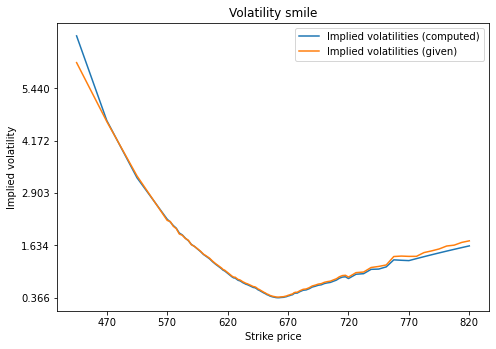

In [7]:
market_price_list=[630.2, 530.35, 430.375, 330.375, 320.4, 310.4, 300.425, 290.375, 280.425, 270.425, 260.45, 250.425, 240.475,
               230.5, 220.525, 210.525, 200.575, 190.625, 180.625, 170.65, 160.7, 155.725, 150.75, 145.75, 140.825, 135.85, 
               130.875, 125.9, 120.925, 115.95, 111.025, 106.225, 101.275, 96.35, 91.575, 86.725, 81.85, 77.075, 72.3, 67.675, 
               63.025, 58.425, 53.875, 49.4, 45.25, 40.925, 36.425, 32.375, 28.3, 24.425, 20.7, 17.325, 14, 11.275, 8.625, 
               6.575, 4.875, 3.575, 2.505, 1.775, 1.265, 0.93, 0.67, 0.475, 0.37, 0.28, 0.245, 0.195, 0.17, 0.135, 0.155, 0.13, 
               0.09, 0.09, 0.08, 0.05, 0.045, 0.05, 0.04, 0.035, 0.025, 0.025, 0.02, 0.015, 0.015, 0.015, 0.02, 0.02, 0.015, 
               0.005, 0.01, 0.005, 0.01, 0.005, 0.005, 0.02, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 
               0.005]


strike_price_list =[100, 200, 300, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 575,
               580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685,
               690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795,
               800, 805, 810, 815, 820, 825, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980,
               990, 1000.0, 1025.0, 1050.0, 1075.0, 1100.0, 1125.0, 1150.0, 1175.0, 1200.0, 1225.0, 1250.0, 1275.0, 1300.0,
               1325.0, 1350.0, 1375.0, 1400.0]

# Implied volatilities as listed on Marketbeat.com
implied_vol_given_list = [6.06195, 4.63453, 3.31565, 2.23785, 2.21292, 2.0969, 2.03894, 1.90917, 1.87824, 1.80033, 1.75746, 
                            1.64899, 1.61048, 1.55225, 1.4933, 1.4209, 1.37375, 1.32376, 1.25259, 1.19155, 1.13842, 1.11119, 
                            1.08355, 1.04859, 1.03362, 1.0046, 0.975283, 0.945672, 0.91578, 0.885605, 0.864444, 0.86212, 
                            0.833109, 0.806976, 0.798624, 0.777865, 0.752547, 0.735303, 0.71525, 0.704378, 0.687509, 0.670471,
                            0.652818, 0.635525, 0.630238, 0.610985, 0.579973, 0.563646, 0.540851, 0.519835, 0.497734, 0.480298,
                            0.456357, 0.442986, 0.421857, 0.40999, 0.39917, 0.392333, 0.383535, 0.380422, 0.380413, 0.38469,
                            0.387874, 0.390514, 0.400084, 0.407405, 0.423622, 0.433224, 0.447941, 0.456497, 0.487009, 0.497606,
                            0.496388, 0.536827, 0.568876, 0.577966, 0.607786, 0.649774, 0.670145, 0.695238, 0.706566, 0.738175,
                            0.754913, 0.766931, 0.796122, 0.824908, 0.873169, 0.901724, 0.908989, 0.864698, 0.973104, 0.987591,
                            1.09743, 1.12328, 1.15919, 1.36356, 1.37417, 1.36704, 1.3681, 1.45891, 1.49971, 1.54655, 1.61797,
                            1.63936, 1.7055, 1.74364]

# Input parameters
S0 = 730
K = 410
r = 0.01
v = 0.1
T = 3/252
n = 10
call_put = 'Call'
exercise_policy = 'European'


implied_vol_list = [0]*len(strike_price_list)


# Compute implied volatility using Newton-Raphson
for i in range(len(market_price_list)):
    market_price = market_price_list[i]
    K = strike_price_list[i]
    implied_vol = compute_implied_volatility(market_price, S0, K, r, T, n, call_put, exercise_policy)
    implied_vol_list[i] = implied_vol
    
 #   print('Strike price: %.3f' % K)
 #   print('Implied volatility: %.3f%%' % (implied_vol * 100))
 #   print('True market price: %.3f' % market_price)
 #   print('Black-Scholes price: %.3f' % black_scholes_call(S0, K, T, r, v),'\n')

    
plot_vol(implied_vol_list, implied_vol_given_list, strike_price_list)